In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### Import Pythia Dataset

In [2]:
with uproot.open("/home/lvaughan/Pythia/pythia/PU_dataset/dataset_mu60.root:pythia") as f:
    trk_pt = f["pT"].array()
    trk_eta = f["eta"].array()
    trk_phi = f["phi"].array()
    trk_label = f["label"].array()
    trk_q = f["q"].array()
with uproot.open("/home/lvaughan/Pythia/pythia/PU_dataset/dataset_mu60.root:fastjet") as f:
    jet_pt = f["jet_pt"].array()
    jet_eta = f["jet_eta"].array()
    jet_phi = f["jet_phi"].array()
    trk_ID = f["trk_ID"].array()

### Define Jet Class

In [3]:
class Jet:
    def __init__(self, jet_features, trk_features, trk_labels):
        self.jet_features = jet_features
        self.trk_features = trk_features
        self.trk_labels = trk_labels
        
    def get_label(self):
        sum_pt_hs = 0
        sum_pt_pu = 0.0000001
        for trk in range(len(self.trk_features)):
            if self.trk_labels[trk]==-1:
                sum_pt_hs+=self.trk_features[trk,0]**2
            else:
                sum_pt_pu+=self.trk_features[trk,0]**2
        return sum_pt_hs / (sum_pt_hs + sum_pt_pu)
    
    def set_label(self, label):
        self.label = np.float32(label)
        
    def set_binary_label(self):
        if self.label == 0:
            self.binary_label = np.float32(0)
        else:
            self.binary_label = np.float32(1)
        
    def convert_to_tensor(self):
        self.trk_features = torch.from_numpy(self.trk_features)
        self.jet_features = torch.from_numpy(self.jet_features)
        self.label = torch.tensor(self.label).reshape([1])
        self.binary_label = torch.tensor(self.binary_label).reshape([1])
        
    def norm_data(self, jet_means, trk_means, jet_stds, trk_stds):
        self.jet_features = torch.div(torch.sub(self.jet_features,jet_means),jet_stds)
        self.trk_features = torch.div(torch.sub(self.trk_features,trk_means),trk_stds)

### Read Raw Data into Jet Class

Processing:  44600  /  44634
Training samples:  26780
Validation samples:  4463
Testing samples:  8713


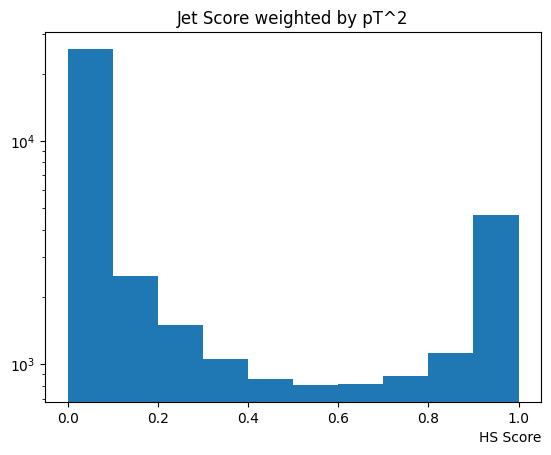

In [4]:
num_jets = len(jet_pt)

Jets = []

for jet in range(num_jets):
    if jet%100==0:
        print("Processing: ", jet, " / ", num_jets, end="\r")
    if abs(jet_eta[jet]) > 4:
        continue
    jet_feats = np.array([jet_pt[jet],jet_eta[jet],jet_phi[jet]], dtype=np.float32)
    trk_feats = np.empty((0,4), dtype=np.float32)
    for trk in trk_ID[jet]:
        # ALTAS uses 400MeV cut
        if trk_pt[trk] < 0.4:
            continue
        # Implement eta cuts on tracks
        if abs(trk_eta[trk]) > 4:
            continue
        # Skip neutral particles
        if trk_q[trk]==0:
            continue
        trk_feats = np.vstack((trk_feats, np.array([trk_pt[trk], trk_eta[trk], trk_phi[trk], trk_label[trk]], dtype=np.float32)))
    Jets.append(Jet(jet_feats,trk_feats[:,0:3],trk_feats[:,-1]))
    
random.shuffle(Jets)

Jets_training = Jets[0:int(0.6*num_jets)]
Jets_validation = Jets[int(0.6*num_jets):int(0.7*num_jets)]
Jets_testing = Jets[int(0.7*num_jets):-1]

print()
print("Training samples: ", len(Jets_training))
print("Validation samples: ", len(Jets_validation))
print("Testing samples: ", len(Jets_testing))

label = []
for jet in Jets:
    jet.set_label(jet.get_label())
    jet.set_binary_label()
    jet.convert_to_tensor()
    
    # List for plotting labels
    label.append(float(jet.label[0].numpy()))
    
plt.hist(label)
plt.title("Jet Score weighted by pT^2")
plt.xlabel("HS Score",loc='right')
plt.yscale('log')

### Normalize Dataset wrt Training Sample

In [5]:
def Norm_Dataset(Jet_List):
    jets = []
    trks = []
    
    for jet in Jet_List:
        jets.append(torch.unsqueeze(jet.jet_features,0))
        trks.append(jet.trk_features)     
    cat_jets = torch.cat(jets,0)
    cat_trks = torch.cat(trks,0)
    
    jet_means = torch.mean(cat_jets,0)
    trk_means = torch.mean(cat_trks,0)
    jet_stds = torch.std(cat_jets,0)
    trk_stds = torch.std(cat_trks,0)
    
    return jet_means, trk_means, jet_stds, trk_stds
    
jet_means, trk_means, jet_stds, trk_stds = Norm_Dataset(Jets_training)
for jet in Jets:
    jet.norm_data(jet_means, trk_means, jet_stds, trk_stds)

Mean:  0.0007785773
STD:  1.0072708


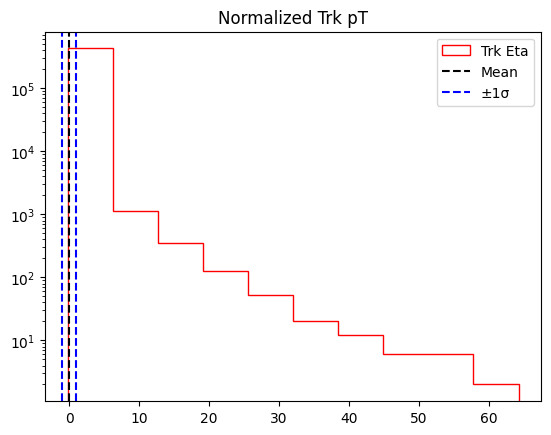

In [6]:
trk_eta = []
for jet in Jets:
    for trk_feats in jet.trk_features:
        trk_eta.append(trk_feats[0])

mean = np.mean(trk_eta)
std = np.std(trk_eta)
print("Mean: ", mean)
print("STD: ", std)
plt.hist(trk_eta, color='r', histtype="step", label="Trk Eta")
plt.axvline(x = mean, color="k", linestyle="--", label="Mean")
plt.axvline(x = std, color="b", linestyle="--", label="\u00B11\u03C3")
plt.axvline(x = -1*std, color="b", linestyle="--")
plt.title("Normalized Trk pT")
plt.yscale('log')
plt.legend()
plt.show()

### Define DataLoader

In [7]:
def Batch_Data(Jet_List):
    # Loop through number of minibatches and cat padded tensors
    minibatch_size = 128
    minibatches = int(len(Jet_List)/minibatch_size)
    batched_data_jets = []
    batched_data_trks = []
    labels = []
    binary_labels = []

    for i in range(minibatches):
        batch_tensors_trk = []
        batch_tensors_jet = []
        batch_labels = []
        batch_binary_labels = []

        index_start = i*minibatch_size
        index_stop = (i+1)*minibatch_size
        
        # Determine max number of tracks per jet PER BATCH
        max_list = []
        for jet in Jet_List[index_start:index_stop]:
            max_list.append(len(jet.trk_features))
        max_num_trks = max(max_list)

        for jet in Jet_List[index_start:index_stop]:
            
            out_jet = torch.unsqueeze(jet.jet_features,0)
            batch_tensors_jet.append(out_jet)
            batch_labels.append(jet.label)
            batch_binary_labels.append(jet.binary_label)

            pad = (0,0,0,max_num_trks-len(jet.trk_features))
            out_trk = F.pad(jet.trk_features,pad)
            out_trk = torch.unsqueeze(out_trk,0)
            batch_tensors_trk.append(out_trk)    

        batch_jet = torch.cat(batch_tensors_jet)
        batched_data_jets.append(batch_jet)
        batch_trk = torch.cat(batch_tensors_trk)
        batched_data_trks.append(batch_trk)
        batch_labels = torch.cat(batch_labels).reshape([minibatch_size,1])
        labels.append(batch_labels)
        batch_binary_labels = torch.cat(batch_binary_labels).reshape([minibatch_size,1])
        binary_labels.append(batch_binary_labels)
        
    return batched_data_jets, batched_data_trks, labels, binary_labels

### Define Model

In [8]:
class Model(nn.Module):  
    def __init__(self):
        super(Model, self).__init__()   
        
        self.embed_dim = 64
        self.num_heads = 8
        self.num_feats = 3
        
        self.jet_initializer = nn.Linear(self.num_feats, self.embed_dim)
        self.trk_initializer = nn.Linear(self.num_feats, self.embed_dim)
        
        self.multihead_attn = nn.MultiheadAttention(self.embed_dim, self.num_heads,batch_first=True)
        
        self.regression = nn.Linear(self.embed_dim*2, 1)
        
        self.classification = nn.Linear(self.embed_dim*2, 1)
        
    def forward(self, jet_batch, trk_batch):
        trk_init = F.relu(self.trk_initializer(trk_batch))
        jet_init = F.relu(self.jet_initializer(jet_batch))
        
        query = trk_init
        key = trk_init
        value = trk_init
        
        trk_embedding, trk_weights = self.multihead_attn(query, key, value)
        
        trk_aggregated = trk_embedding.sum(dim=1)
            
        jet_embedding = torch.cat((jet_init, trk_aggregated),1)
             
        output = F.sigmoid(self.regression(jet_embedding))
        
        binary_classification = F.sigmoid(self.classification(jet_embedding))
        
        return output, binary_classification, trk_weights

### Define Training Loop

In [9]:
def train(model, data, epochs=100):
    train_data, validation_data = data
    
    jets_train_batched, trks_train_batched, train_labels, train_binary_labels = Batch_Data(train_data)
    jets_val_batched, trks_val_batched, val_labels, val_binary_labels = Batch_Data(validation_data)
    
    combined_history = []
    mse_history = []
    bce_history = []
    
    num_train = len(train_labels)
    num_val = len(val_labels)
    
    for e in range(epochs):
        model.train()
        cumulative_MSE_train = 0
        cumulative_BCE_train = 0
        cumulative_loss_train = 0

        for batch in range(num_train):
            optimizer.zero_grad()
            
            output, binary, weights = model(jets_train_batched[batch].to(device), trks_train_batched[batch].to(device))
            
            loss_MSE=loss_fn1(output, train_labels[batch].to(device))
            loss_BCE=loss_fn2(binary, train_binary_labels[batch].to(device))
            loss = ALPHA * loss_MSE + BETA * loss_BCE
            loss.backward()
            optimizer.step()
            
            cumulative_loss_train+=loss.detach().cpu().numpy().mean()
            cumulative_MSE_train+=loss_MSE.detach().cpu().numpy().mean()
            cumulative_BCE_train+=loss_BCE.detach().cpu().numpy().mean()

        cumulative_loss_train = cumulative_loss_train / num_train
        cumulative_MSE_train = cumulative_MSE_train / num_train
        cumulative_BCE_train = cumulative_BCE_train / num_train

        
        model.eval()
        cumulative_MSE_val = 0
        cumulative_BCE_val = 0
        cumulative_loss_val = 0
        for batch in range(num_val):
            output, binary, weights = model(jets_val_batched[batch].to(device), trks_val_batched[batch].to(device))
            loss_MSE=loss_fn1(output, val_labels[batch].to(device))
            loss_BSE=loss_fn2(binary, val_binary_labels[batch].to(device))
            loss = ALPHA * loss_MSE + BETA * loss_BCE
            cumulative_loss_val+=loss.detach().cpu().numpy().mean()
            cumulative_MSE_val+=loss_MSE.detach().cpu().numpy().mean()
            cumulative_BCE_val+=loss_BCE.detach().cpu().numpy().mean()
            
        cumulative_loss_val = cumulative_loss_val / num_val
        cumulative_MSE_val = cumulative_MSE_val / num_val
        cumulative_BCE_val = cumulative_BCE_val / num_val

        
        combined_history.append([cumulative_loss_train, cumulative_loss_val])
        mse_history.append([cumulative_MSE_train, cumulative_MSE_val])
        bce_history.append([cumulative_BCE_train, cumulative_BCE_val])

        if e%10==0:
            print('Epoch:',e,'\tTrain Loss:',round(cumulative_loss_train,6),'\tVal Loss:',round(cumulative_loss_val,6))

    return np.array(combined_history), np.array(mse_history), np.array(bce_history)

### Train Model

In [10]:
print("GPU Available: ", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print()

model = Model()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_fn1 = nn.MSELoss()
loss_fn2 = nn.BCELoss()
# Combined Loss = ALPHA * MSE + BETA * BCE
ALPHA = 1    # Weight of MSE Loss
BETA = 1    # Weight of BCE Loss
combined_history, mse_history, bce_history = train(model, [Jets_training, Jets_validation])

GPU Available:  True
cuda:0

Epoch: 0 	Train Loss: 0.757013 	Val Loss: 0.713427
Epoch: 10 	Train Loss: 0.637535 	Val Loss: 0.657888
Epoch: 20 	Train Loss: 0.633454 	Val Loss: 0.65974
Epoch: 30 	Train Loss: 0.631462 	Val Loss: 0.662896
Epoch: 40 	Train Loss: 0.63019 	Val Loss: 0.664959
Epoch: 50 	Train Loss: 0.62931 	Val Loss: 0.665879
Epoch: 60 	Train Loss: 0.628629 	Val Loss: 0.666089
Epoch: 70 	Train Loss: 0.628081 	Val Loss: 0.666062
Epoch: 80 	Train Loss: 0.627626 	Val Loss: 0.665928
Epoch: 90 	Train Loss: 0.627222 	Val Loss: 0.665834


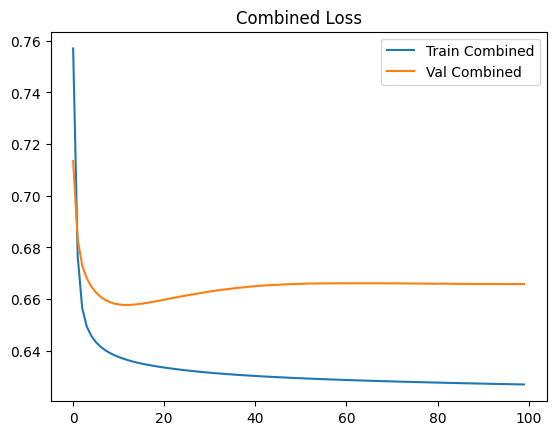

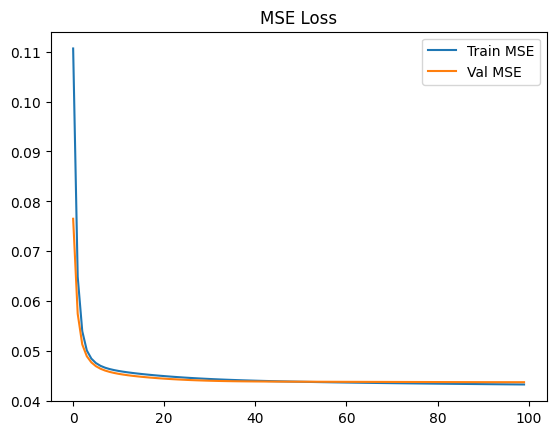

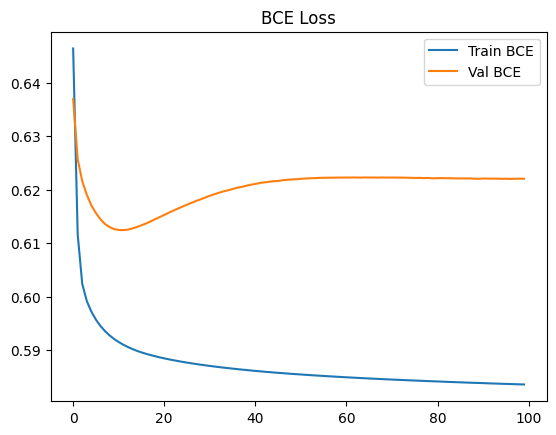

In [11]:
plt.plot(combined_history[:,0], label="Train Combined")
plt.plot(combined_history[:,1], label="Val Combined")
plt.title('Combined Loss')
plt.legend()
plt.show()
plt.plot(mse_history[:,0], label="Train MSE")
plt.plot(mse_history[:,1], label="Val MSE")
plt.title('MSE Loss')
plt.legend()
plt.show()
plt.plot(bce_history[:,0], label="Train BCE")
plt.plot(bce_history[:,1], label="Val BCE")
plt.title('BCE Loss')
plt.legend()
plt.show()

### Visualize Attention Scores

tensor([[0.9091]], device='cuda:0', grad_fn=<SigmoidBackward0>)


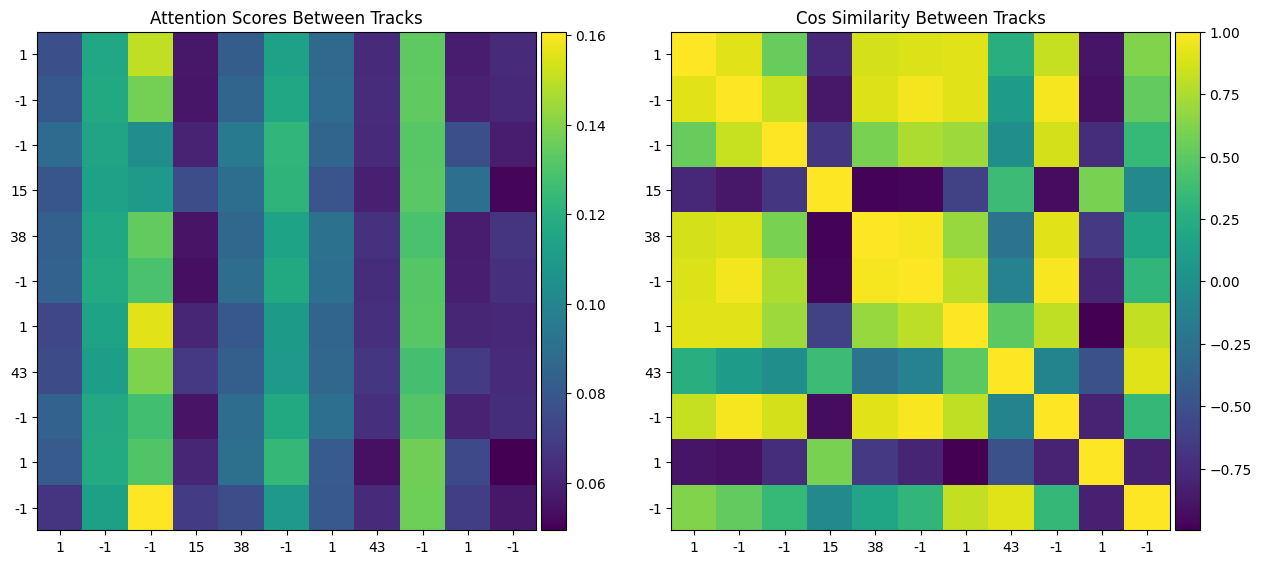

tensor([[0.9451]], device='cuda:0', grad_fn=<SigmoidBackward0>)


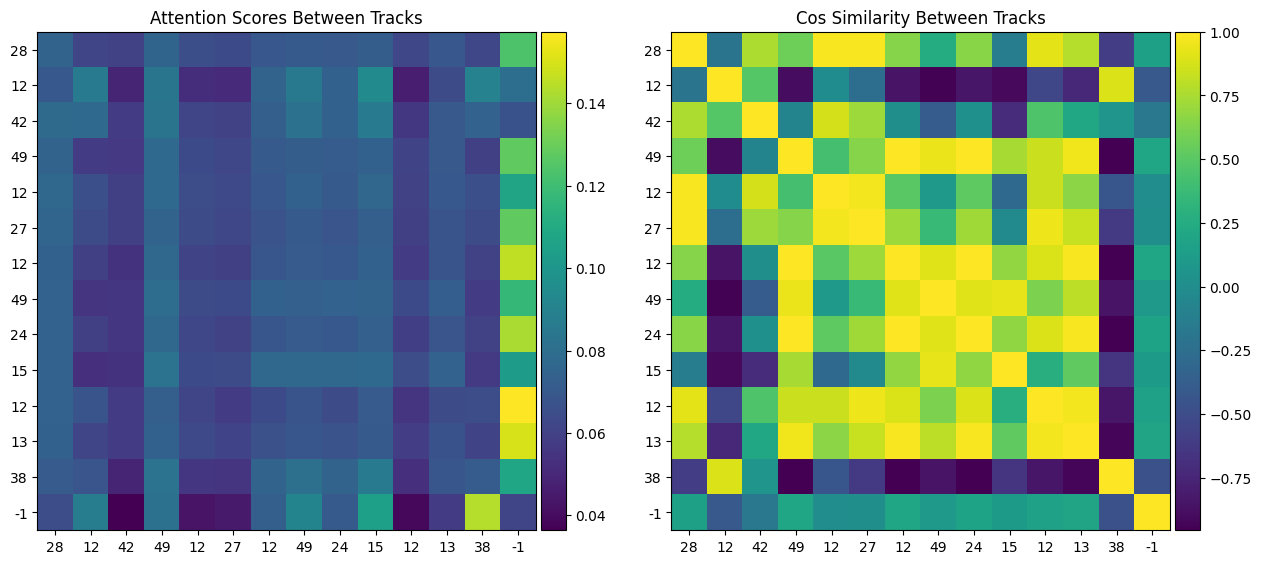

tensor([[0.8805]], device='cuda:0', grad_fn=<SigmoidBackward0>)


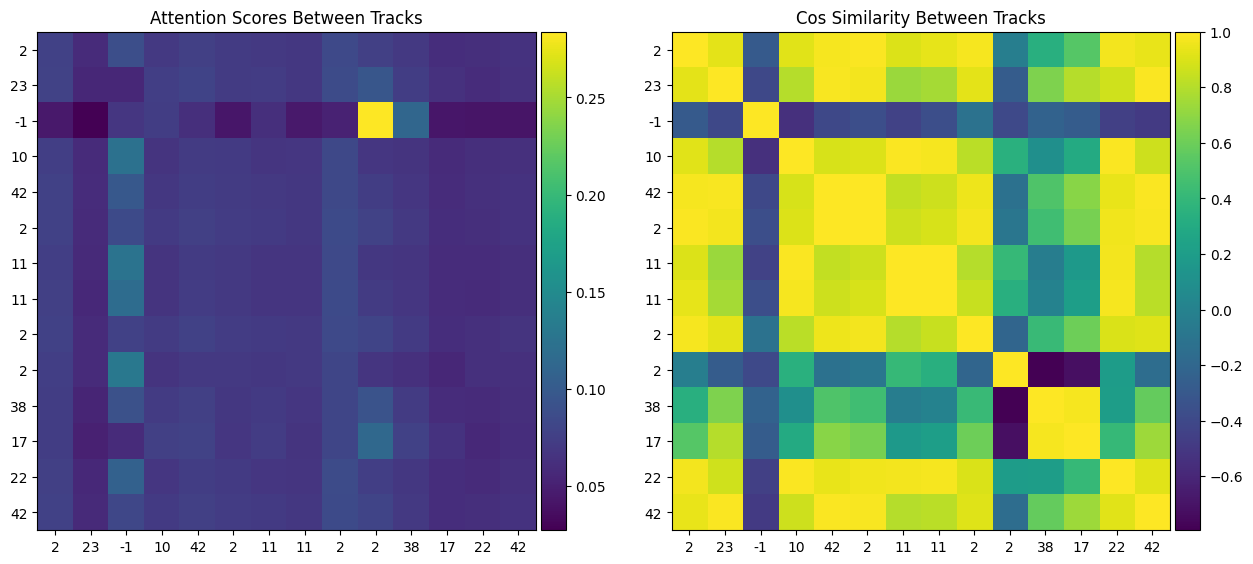

In [12]:
hs_idx = np.where(np.array([float(jet.label[0].numpy()) for jet in Jets_testing]) > 0.9)[0]

plotting_num=3

for i in range(plotting_num):
    jet_no = hs_idx[i]

    # Get Model Predictions
    model.eval()
    output, binary, weights = model(torch.unsqueeze(Jets_testing[jet_no].jet_features,0).to(device), torch.unsqueeze(Jets_testing[jet_no].trk_features,0).to(device))

    print(binary)
    
    # Define subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
    
    # Calculate tick labels
    ticks = [x for x in range(len(Jets_testing[jet_no].trk_features))]
    tick_labels = []
    for trk in range(len(Jets_testing[jet_no].trk_features)):
        tick_labels.append(int(Jets_testing[jet_no].trk_labels[trk]))
    
    # Plot attention weights
    im1 = ax1.imshow(weights[0].detach().cpu().numpy())
    ax1.set_xticks(ticks, tick_labels)
    ax1.set_yticks(ticks, tick_labels)
    ax1.set_title("Attention Scores Between Tracks")
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')

    # Calculate cos similiarity matrix
    num_trks = len(Jets_testing[jet_no].trk_features)
    cos_sim_matrix = np.zeros((num_trks,num_trks))
    for i in range(num_trks):
        feats1 = Jets_testing[jet_no].trk_features[i].numpy()
        A = np.linalg.norm(feats1)
        for j in range(i,num_trks):
            feats2 = Jets_testing[jet_no].trk_features[j].numpy()
            B = np.linalg.norm(feats2)
            cos_sim_matrix[i,j] = np.dot(feats1,feats2) / (A*B)
            cos_sim_matrix[j,i] = cos_sim_matrix[i,j]
    
    # Plot cos similiarity matrix
    im2 = ax2.imshow(cos_sim_matrix)  
    ax2.set_xticks(ticks, tick_labels)
    ax2.set_yticks(ticks, tick_labels)
    ax2.set_title("Cos Similarity Between Tracks")
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im2, cax=cax, orientation='vertical')
    
    plt.show()    

### Evaluate Model

Train Loss:	 0.6268957262974607
Val Loss:	 0.6657879790839027
Test Loss:	 0.6283704007373137


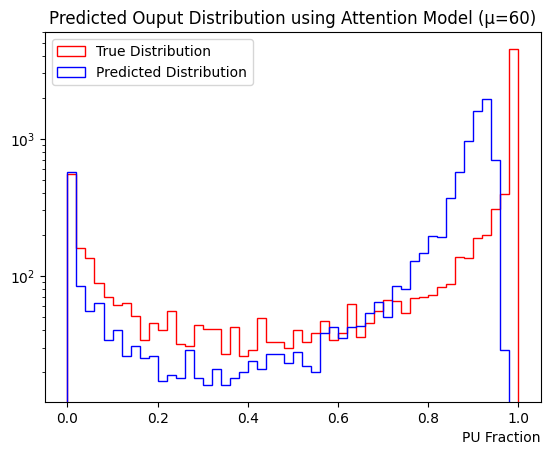

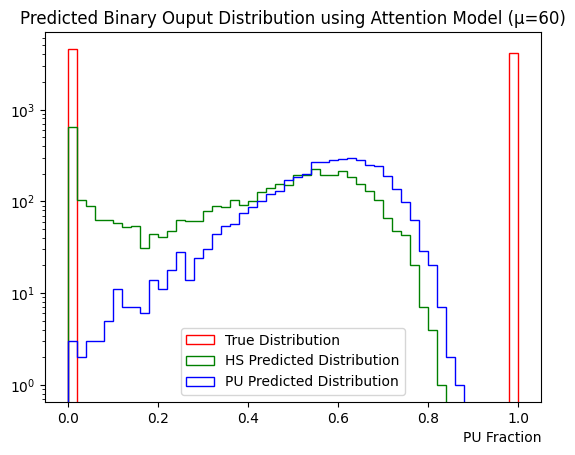

In [16]:
model.eval()
cumulative_loss_test = 0
predicted_labels = []
true_labels = []
binary_pred = []
binary_true = []

jets_test_batched, trks_test_batched, test_labels, test_binary_labels = Batch_Data(Jets_testing)

for batch in range(len(test_labels)):
    output, binary, weights = model(jets_test_batched[batch].to(device), trks_test_batched[batch].to(device))
    
    for i in range(output.shape[0]):        
        predicted_labels.append(1-float(output[i][0].detach().cpu().numpy()))
        true_labels.append(1-float(test_labels[batch][i][0].detach().numpy()))
        binary_pred.append(1-float(binary[i][0].detach().cpu().numpy()))
        binary_true.append(1-float(test_binary_labels[batch][i][0].detach().numpy()))
    
    loss_MSE=loss_fn1(output, test_labels[batch].to(device))
    loss_BCE=loss_fn2(binary, test_binary_labels[batch].to(device))
    loss = ALPHA * loss_MSE + BETA * loss_BCE
    cumulative_loss_test+=loss.detach().cpu().numpy().mean()
    
cumulative_loss_test = cumulative_loss_test / len(test_labels)
    
print("Train Loss:\t", combined_history[-1][0])
print("Val Loss:\t", combined_history[-1][1])
print("Test Loss:\t", cumulative_loss_test)

plt.hist(true_labels,histtype='step',color='r',label='True Distribution',bins=50,range=(0,1))
plt.hist(predicted_labels,histtype='step',color='b',label='Predicted Distribution',bins=50,range=(0,1))
plt.title("Predicted Ouput Distribution using Attention Model (\u03BC=60)")
plt.legend()
plt.yscale('log')
plt.xlabel('PU Fraction',loc='right')
plt.show()

binary_true = np.array(binary_true)
binary_pred = np.array(binary_pred)
PU_idxs = np.where(binary_true == 1)
HS_idxs = np.where(binary_true == 0)

plt.hist(binary_true,histtype='step',color='r',label='True Distribution',bins=50,range=(0,1))
plt.hist(binary_pred[HS_idxs],histtype='step',color='g',label='HS Predicted Distribution',bins=50,range=(0,1))
plt.hist(binary_pred[PU_idxs],histtype='step',color='b',label='PU Predicted Distribution',bins=50,range=(0,1))
plt.title("Predicted Binary Ouput Distribution using Attention Model (\u03BC=60)")
plt.legend()
plt.yscale('log')
plt.xlabel('PU Fraction',loc='right')
plt.show()